In [93]:
from sklearn.datasets import fetch_openml
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep
from phate import PHATE

from sklearn.model_selection import train_test_split

In [94]:
# data = fetch_openml(name='tic-tac-toe', version=1, as_frame=True)

# x = data['data']
# y = data['target']
# y = pd.Categorical(y).codes
# x = dataprep(x, label_col_idx = None, scale = None)

In [95]:
# data   = pd.read_csv('../datasets/2_class_normal.csv', sep = ',')
data   = pd.read_csv('../datasets/iris.csv', sep = ',')
x, y   = dataprep(data)
n, d   = x.shape
n_classes = len(y.unique())

In [96]:
from scipy.spatial.distance import pdist

pdist(x)[0:5]

array([0.21561354, 0.16810102, 0.21761244, 0.0500771 , 0.2103619 ])

In [97]:
x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.1, random_state = 42)

In [98]:
rf = RFGAP(oob_score = True, non_zero_diagonal = False, random_state = 42) #non_zero_diagonal must be false
rf.fit(x, y)
prox = rf.get_proximities()

In [99]:
rf2 = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42) #non_zero_diagonal must be false for trust
rf2.fit(x, y)
prox2 = rf2.get_proximities()

In [100]:
rf3 = RFGAP(oob_score = True, non_zero_diagonal = False, random_state = 42)
rf3.fit(x_train, y_train)
prox3 = rf3.get_proximities()

In [101]:
trust_scores = rf.get_trust_scores()
trust_scores_test = rf3.get_test_trust(x_test)

Currently minus not taking oob_correct into account


<Axes: ylabel='Density'>

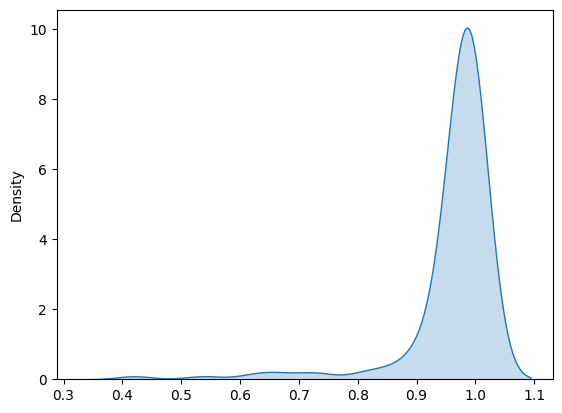

In [102]:
sns.kdeplot(trust_scores, fill = True)

In [103]:
y.shape

(150,)

In [104]:
x['trust'] = rf.trust_scores
x['class'] = y

In [105]:
# sns.pairplot(x, hue = 'class', plot_kws = {'s': 10})

In [106]:
def rescale(x):
    # return 100 - (x - x.min())/(x.max() - x.min()) * 100 + 5
    return 100 - x/x.max() * 100 + 5

In [107]:
phate_op = PHATE(knn_dist = 'precomputed')
emb = phate_op.fit_transform(prox2)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 150 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 2
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.05 seconds.
Calculated PHATE in 0.10 seconds.


<Axes: >

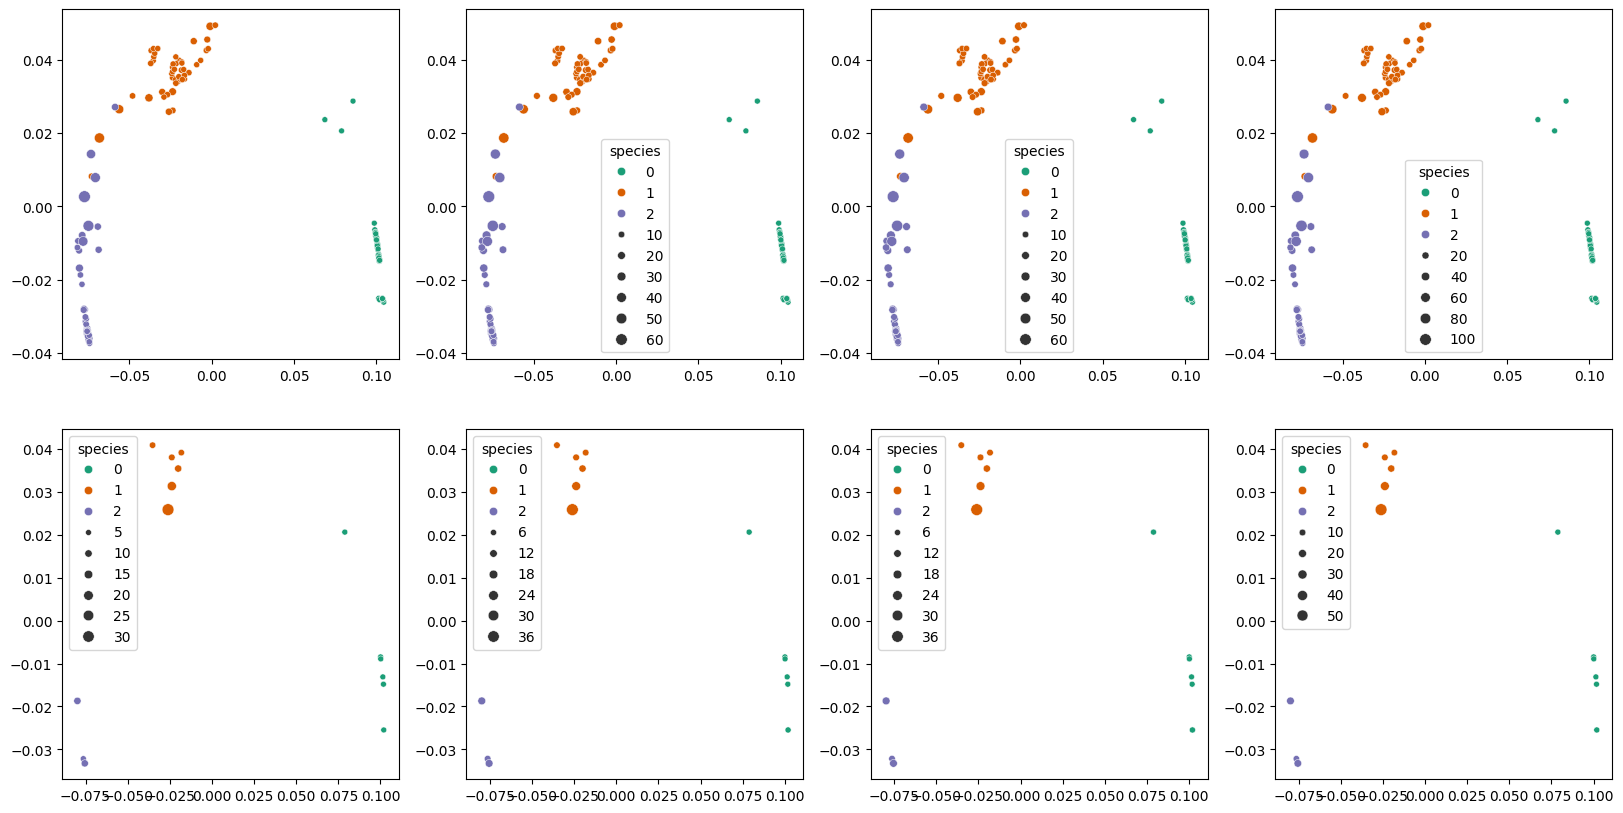

In [108]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))

sns.scatterplot(ax = axes[0, 0], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_scores), palette = 'Dark2', legend = False)
sns.scatterplot(ax = axes[0, 1], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_correct_proba), palette = 'Dark2')
sns.scatterplot(ax = axes[0, 2], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_max_proba), palette = 'Dark2') 
sns.scatterplot(ax = axes[0, 3], x = emb[:, 0], y = emb[:, 1], hue = y, size = rescale(rf.trust_minus), palette = 'Dark2')

sns.scatterplot(ax = axes[1, 0], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_scores_test), palette = 'Dark2')
sns.scatterplot(ax = axes[1, 1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_correct_proba_test), palette = 'Dark2')
sns.scatterplot(ax = axes[1, 2], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_max_proba_test), palette = 'Dark2') 
sns.scatterplot(ax = axes[1, 3], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_minus_test), palette = 'Dark2')

# plt.scatter(emb[483, 0], emb[483, 1], s = 100, c = 'r', marker = 'x')
# axes[0, 0].legend.remove()



In [109]:
trust_above_oob = rf.trust_scores > rf.oob_score_

print(sum(trust_above_oob) / len(y))

0.84


<Axes: >

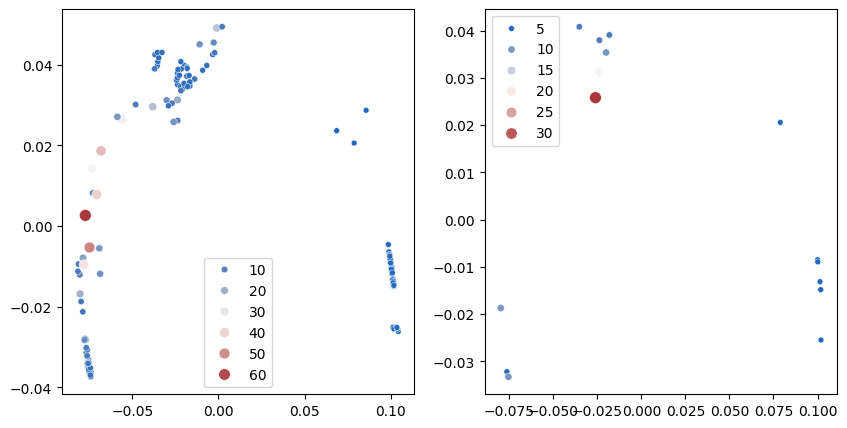

In [110]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

color_palette = sns.color_palette('vlag', as_cmap = True)

sns.scatterplot(ax = axes[0], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_scores), size = rescale(rf.trust_scores), palette = color_palette)
sns.scatterplot(ax = axes[1], x = emb[inds_test, 0], y = emb[inds_test, 1], hue = rescale(rf3.trust_scores_test), size = rescale(rf3.trust_scores_test), palette = color_palette)
# sns.scatterplot(ax = axes[2], x = emb[trust_above_oob, 0], y = emb[trust_above_oob, 1], size = rescale(rf.trust_scores)[trust_above_oob], palette = color_palette)

# plt.scatter(emb[49, 0], emb[49, 1], s = 100, c = 'r', marker = 'x')
# plt.scatter(emb[72, 0], emb[72, 1], s = 100, c = 'g', marker = 'x')

In [111]:
trust_threshold_9 = rf.get_trust_threshold(0.9)
trust_threshold_5 = rf.get_trust_threshold(0.1)

diff_top_2_proba = rf.get_max_2_proba_diffs()

In [112]:
print(np.mean(rf.trust_scores[~rf.is_correct_oob]))

0.76278403742024


In [113]:
print(np.mean(rf.trust_scores))

0.9594473710406284


In [114]:
rf.oob_score_

0.9533333333333334

In [115]:
np.sum(rf.prox_predict(x, oob_predict = True) == rf.oob_predictions) / len(y)

1.0

In [116]:
print(np.mean(rf.trust_scores[rf.is_correct_oob]))
print(np.mean(rf.diff_top_2_proba[rf.is_correct_oob]))
print(np.mean(rf.trust_proba_diff[rf.is_correct_oob]))


0.9690742475115566
0.9497563724984375
0.9467800148391655


In [117]:
print(np.mean(rf.trust_scores[~rf.is_correct_oob]))
print(np.mean(rf.diff_top_2_proba[~rf.is_correct_oob]))
print(np.mean(rf.trust_proba_diff[~rf.is_correct_oob]))

0.76278403742024
0.5703657400040916
0.672446222683568


In [118]:
print(np.sum(rf.oob_predictions[rf.trust_scores > rf.oob_score_] == y[rf.trust_scores > rf.oob_score_])/len(y[rf.trust_scores > rf.oob_score_]))

0.9920634920634921


In [119]:
print(np.sum(rf.oob_predictions[rf.trust_scores < rf.oob_score_] == y[rf.trust_scores < rf.oob_score_])/len(y[rf.trust_scores < rf.oob_score_]))

0.75


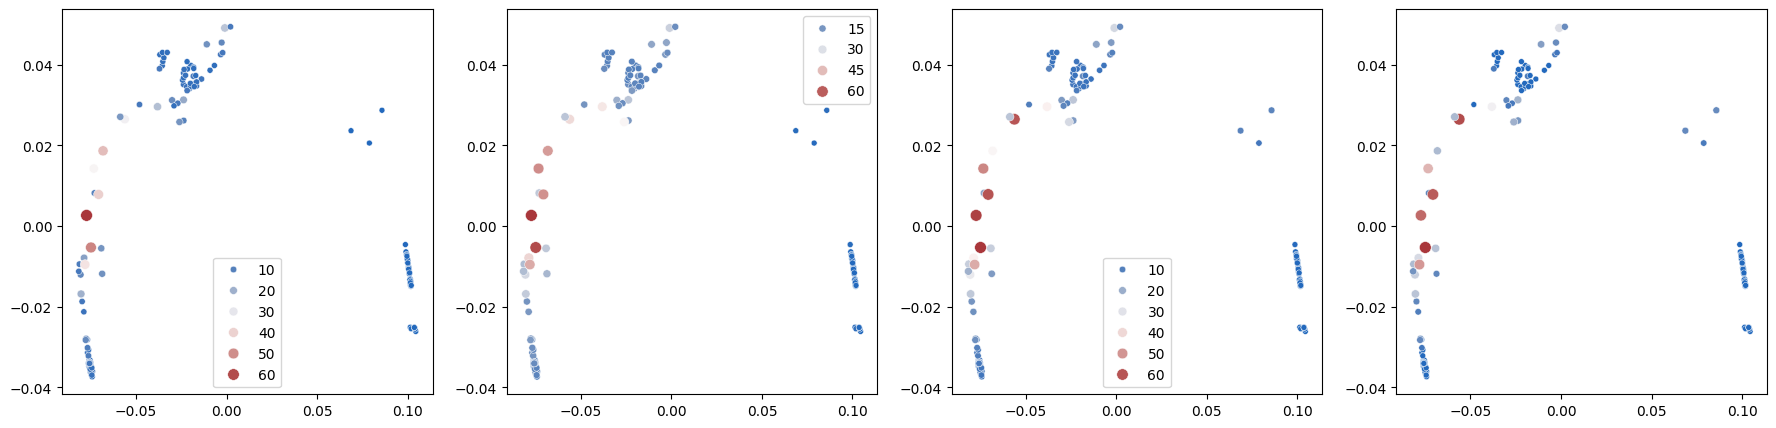

In [120]:
fig, axes = plt.subplots(1, 4, figsize = (22, 5))

sns.scatterplot(ax = axes[0], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_scores), size = rescale(rf.trust_scores), palette = 'vlag')
sns.scatterplot(ax = axes[1], x = emb[:, 0], y = emb[:, 1], hue = rescale(trust_threshold_5), size = rescale(trust_threshold_5), palette = 'vlag')
sns.scatterplot(ax = axes[2], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.trust_proba_diff), size = rescale(rf.trust_proba_diff), palette = 'vlag')
sns.scatterplot(ax = axes[3], x = emb[:, 0], y = emb[:, 1], hue = rescale(rf.diff_top_2_proba), size = rescale(rf.diff_top_2_proba), palette = 'vlag')

axes[3].legend().remove()

In [121]:
rf3.oob_score_

0.9481481481481482

In [122]:
x['oob_correct'] = rf.is_correct_oob
x['diff_top_2_proba'] = rf.diff_top_2_proba
x['trust_proba_diff'] = rf.trust_proba_diff

In [123]:
x.groupby('oob_correct').mean()

sepal_length  sepal_width  petal_length  petal_width     trust  \
oob_correct                                                                   
False            0.511905     0.321429      0.685230     0.636905  0.762784   
True             0.424631     0.444930      0.456916     0.449009  0.969074   

                class  diff_top_2_proba  trust_proba_diff  
oob_correct                                                
False        1.571429          0.570366          0.672446  
True         0.972028          0.949756          0.946780

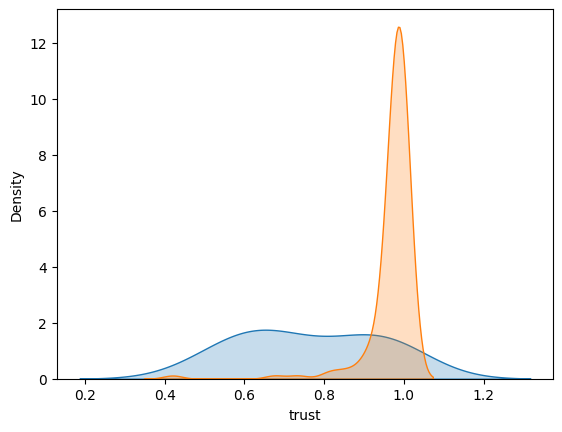

In [124]:
for group in x.groupby('oob_correct'):
    sns.kdeplot(group[1]['trust_max_proba'], fill = True)

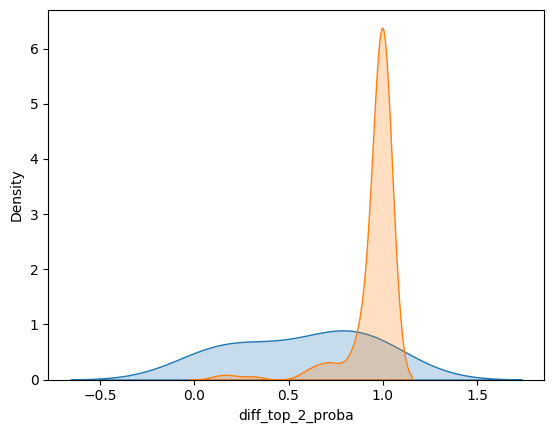

In [125]:
for group in x.groupby('oob_correct'):
    sns.kdeplot(group[1]['diff_top_2_proba'], fill = True)

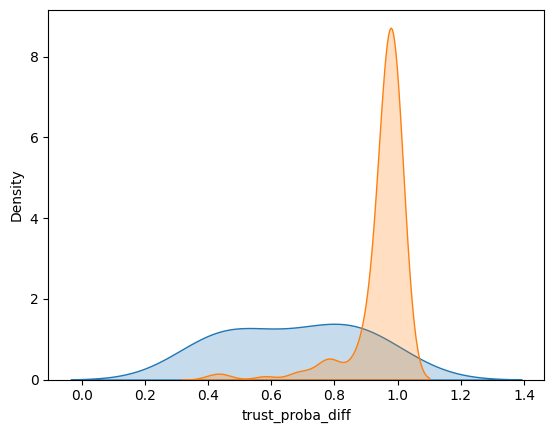

In [126]:
for group in x.groupby('oob_correct'):
    sns.kdeplot(group[1]['trust_proba_diff'], fill = True)

<Axes: xlabel='sepal_length', ylabel='sepal_width'>

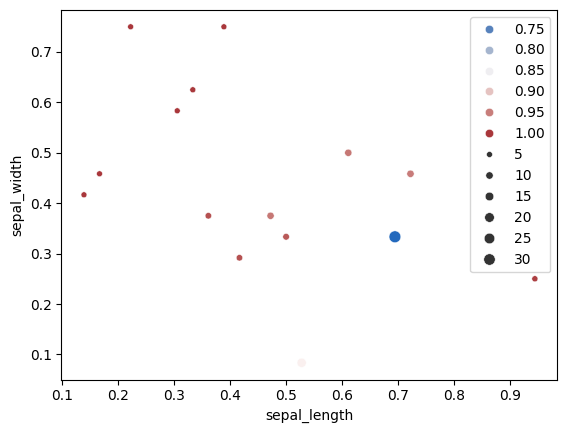

In [127]:
# sns.scatterplot(x = x.iloc[inds_test, 0], y = x.iloc[inds_test, 1], hue = y[inds_test], size = rescale(rf3.trust_scores_test), palette = 'Dark2')
sns.scatterplot(x = x.iloc[inds_test, 0], y = x.iloc[inds_test, 1], hue = rf3.trust_scores_test, size = rescale(rf3.trust_scores_test), palette = 'vlag')

<Axes: xlabel='sepal_length', ylabel='sepal_width'>

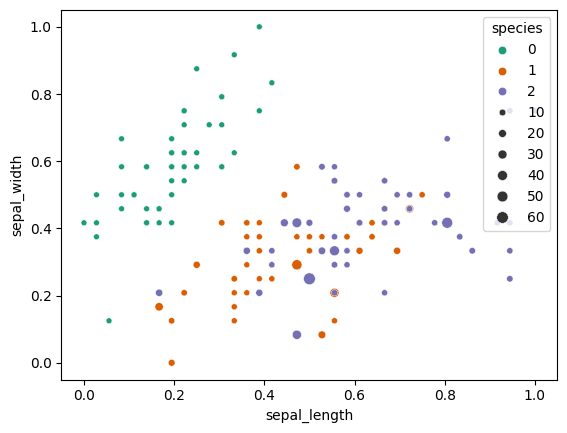

In [128]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = y, size = rescale(rf.trust_scores), palette = 'Dark2')

<Axes: xlabel='sepal_length', ylabel='sepal_width'>

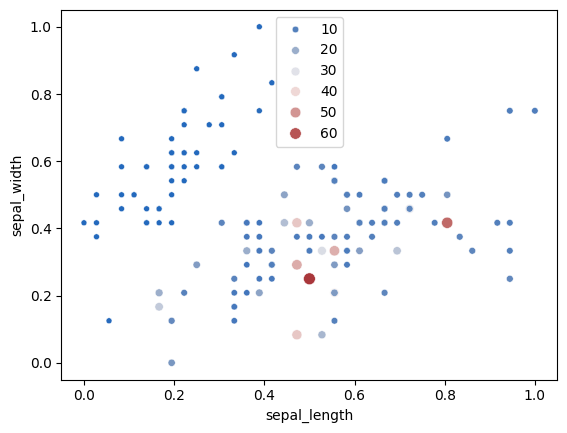

In [129]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = rescale(rf.trust_max_proba), size = rescale(rf.trust_max_proba), palette = 'vlag')

<Axes: xlabel='sepal_length', ylabel='sepal_width'>

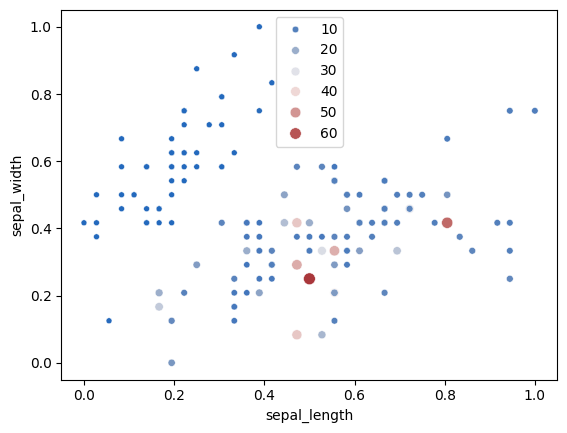

In [130]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = rescale(rf.trust_correct_proba), size = rescale(rf.trust_correct_proba), palette = 'vlag')

<Axes: xlabel='sepal_length', ylabel='sepal_width'>

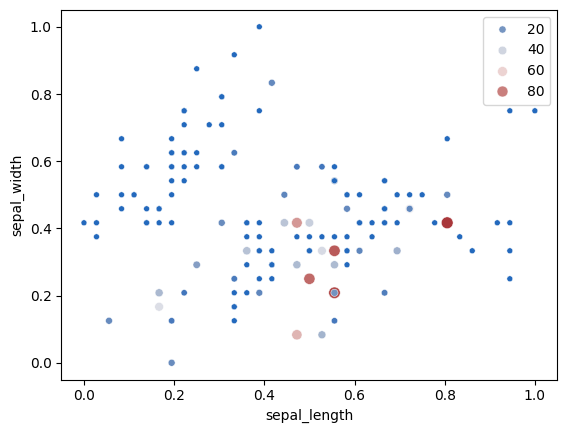

In [131]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = rescale(rf.diff_top_2_proba), size = rescale(rf.diff_top_2_proba), palette = 'vlag')

<Axes: xlabel='sepal_length', ylabel='sepal_width'>

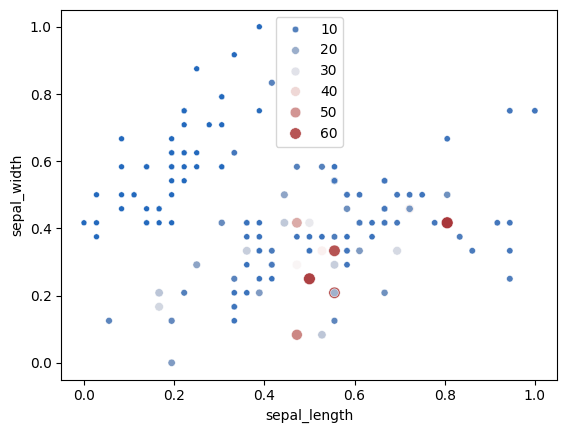

In [132]:
sns.scatterplot(x = x.iloc[:, 0], y = x.iloc[:, 1], hue = rescale(rf.trust_proba_diff), size = rescale(rf.trust_proba_diff), palette = 'vlag')

In [133]:

inds_test[np.argmin(rf3.trust_scores_test)]

76

In [134]:
inds_test[np.argmax(rf3.trust_scores_test)]

18

In [135]:
# TODO: Experiment: make bivariate blobs, but put a point in the middle of the
# opposite blob class. Then, check if the trust score is low for that point under
# a few conditions: 1) with raw trust, 2) with raw trust multiplied by max proba
# 3) with raw trust mutliplied by correct proba.